# Project 'WHO suicide statistics predictions'

WHO suicide statistics predictions for European Union country-members.

In [1]:
import math
import pathlib
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score

Make result reproducible by emphasize random seed

In [2]:
np.random.seed(seed=158)

## Loading data set

In [3]:
path_material = pathlib.Path('data\\raw_data.csv')

In [4]:
df_raw = pd.read_csv(path_material, low_memory=False)

## Data pre-processing

Brief overall data set description

In [5]:
df_raw.describe()

,year,population,foreign_exch_reserve,GPD_per_cap,Unemployment,Inflation_rate,Life_length_expectancy,GINI,ARMS_export,ARMS_import,Corruption_perception,Temperature_JAN,Temperature_JUL,suicides_no
count,7248.000000,7.248000e+03,7.176000e+03,7248.000000,7092.000000,7248.000000,7248.000000,4656.000000,4.872000e+03,6.384000e+03,4764.000000,7248.000000,7248.000000,7248.000000
mean,2001.774834,1.743408e+06,3.469842e+10,26893.020251,8.820021,3.470996,77.562979,31.333763,6.209064e+08,2.277538e+08,21.985516,1.868540,19.271537,217.996551
std,10.055130,2.235278e+06,3.911449e+10,18015.963059,4.311936,3.911775,2.718098,3.608685,8.498247e+08,3.152652e+08,26.615663,5.127656,3.454063,425.938170
min,1979.000000,5.900000e+03,9.746575e+07,3861.948500,1.482400,-4.478103,70.865854,23.000000,0.000000e+00,0.000000e+00,3.330000,-16.194000,12.571100,0.000000
25%,1995.000000,3.024238e+05,6.400005e+09,13585.207562,5.856900,1.417741,75.475287,28.200000,2.500000e+07,2.400000e+07,6.100000,-1.093000,16.649850,9.000000
50%,2004.000000,7.447485e+05,2.160458e+10,23102.007735,7.865600,2.452733,77.636585,31.350000,2.080000e+08,1.045000e+08,8.000000,2.732625,18.887950,63.000000
75%,2010.000000,2.538383e+06,4.807903e+10,35575.159547,10.554500,4.053958,79.793293,34.300000,9.510000e+08,2.865000e+08,42.000000,5.044645,21.743575,214.000000
max,2016.000000,1.314881e+07,2.490000e+11,118823.648400,27.466200,24.506067,83.229268,39.000000,4.037000e+09,2.167000e+09,92.000000,22.723500,29.786000,3427.000000


In [6]:
def refactor_titles(df: pd.DataFrame, sub_chars=[' ','-',':'], drop_chars=['(',')','[',']']) -> list:
    '''
    Function generalizes all column titles, i.e. lowers all cases, makes characters 
    substitution from one input list and drops characters from another input list.
    (1) df --> DataFrame which columns function should transform;
    (2) sub_chars --> characters to substitute with '_';
    (3) drop_chars --> characters to drop;
    Returns list with new column titles.
    '''
    list_columns = [item.lower() for item in (df.columns.tolist())]   
    for sub_char in sub_chars:
        counter_sub = 0
        for i in range(len(list_columns)):
            if sub_char in list_columns[i]:
                counter_sub += 1
                list_columns[i] = list_columns[i].replace(sub_char, '_')
            else:
                continue
        print(f'Substituotion of "{sub_char}" occured {counter_sub} times.')
    for drop_char in drop_chars:
        counter_drop = 0
        for i in range(len(list_columns)):
            if drop_char in list_columns[i]:
                list_columns[i] = list_columns[i].replace(drop_char, '') 
            else:
                continue
            print(f'Drop of "{drop_char}" occured {counter_drop} times.')              
    return list_columns

### Refactor columns titles

Initialize **refactor_titles()** function (it changes all titles to lower cases along with substituting and dropping several uncommon characters) on the DataFrame's columns

In [7]:
df_raw.columns = refactor_titles(df_raw)

Substituotion of " " occured 0 times.
Substituotion of "-" occured 0 times.
Substituotion of ":" occured 0 times.


### Update 'corruption perception' feature evaluation changes from 2012

After 2012 Corruption perception evaluation changes from range 10 to range 100.
In order to generalize column, all values after 2012 will be divided by 10.

In [8]:
df_raw['corruption_perception'] = df_raw['corruption_perception'].apply(lambda x: x/10 if x > 10 else x)

### NaN values | part 1

Check the DataFrame for null-values.

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 7248 non-null   object 
 1   year                    7248 non-null   int64  
 2   sex                     7248 non-null   object 
 3   age                     7248 non-null   object 
 4   population              7248 non-null   int64  
 5   foreign_exch_reserve    7176 non-null   float64
 6   gpd_per_cap             7248 non-null   float64
 7   unemployment            7092 non-null   float64
 8   inflation_rate          7248 non-null   float64
 9   life_length_expectancy  7248 non-null   float64
 10  gini                    4656 non-null   float64
 11  arms_export             4872 non-null   float64
 12  arms_import             6384 non-null   float64
 13  corruption_perception   4764 non-null   float64
 14  temperature_jan         7248 non-null   

####  *ARMS import* and *ARMS export* features

All empty values in both ARMS import and ARMS export columns will be filled with '0', as these countries didn't participate neither in ARMS import nor in ARMS export.

In [10]:
df_raw['arms_import'].fillna(0, inplace=True)
df_raw['arms_export'].fillna(0, inplace=True)

#### *Foreign exchange* reserve and *Unemployment* features

Derive column names containing at least one NaN value, put them into list and assign to variable.
Define function to attach country names where NaN appeared and return dictionary with countries.

In [11]:
def nan_columns_by_country(df: pd.DataFrame, column_mark: str) -> dict:
    '''Function identifies column names in a given DataFrame containing at 
    least one NaN value, puts them into a list and assigns it to variable
    'columns_nan_list'. Then it takes input 'column_nan' column and 
    checks if it is in 'columns_nan_list'. If not, proceed further. 
    The last action is iterations through each NaN column and grouping
    by 'column_nan' categories in it.
    Parameters:
    -----------
    (1) df --> given DataFrame;
    (2) column_nan --> categorical column, each one will be filtered for NaN values;
    -----------
    Returns dictionary with given column categorical values and count of NaN values in it.
    '''
    columns_nan_list = df.columns[df.isna().any()].tolist()
    if column_mark in columns_nan_list:
        return print(f'Column {column_nan} has NaN values, please choose another column')
    set_of_nan = {}
    for column in columns_nan_list:
        set_of_nan[column] = list(set(df[df[column].isnull()][column_mark]))
    for key, value in sorted(set_of_nan.items()):
        print(f'* {len([item for item in value if item])} categories in column "{column_mark}" with at least one NaN in "{key}".')
    return set_of_nan

Initialize function **nan_columns_by_country()**.
Function returns 4 columns: foreign_exch_reserve | unemployment | gini | corruption_perception.
Let's take 'foreign_exch_reserve' & 'unemployment' as only several countries have missing values.

In [12]:
columns_nan_dict = nan_columns_by_country(df_raw,'country')

* 22 categories in column "country" with at least one NaN in "corruption_perception".
* 1 categories in column "country" with at least one NaN in "foreign_exch_reserve".
* 16 categories in column "country" with at least one NaN in "gini".
* 4 categories in column "country" with at least one NaN in "unemployment".


Define function to fill NaN values using .fillna() with 'backfill' method.

In [13]:
def backfilling_nan_by_country(df: pd.DataFrame, columns_nan_dict: dict, target_column: str, category_column: str):
    '''Function fills NaN values directly into given DataFrame using 'backfill' method.
    Parameters:
    -----------
    (1) df --> given DataFrame;
    (2) columns_nan_dict --> dictionary with all NaN columns as a key and all NaN categories from category_column;
    (3) target_column --> column name where NaN values will be filled using 'backfill' method;
    (4) category_column --> column name where categories have NaN values in 'target_column';
    -----------
    Returns text confirmation that NaN values were filled, otherwise text confirmation that no NaN occured.
    '''
    if df_raw[target_column].isnull().any():
        for nan_category in columns_nan_dict[target_column]:
            mask = (df[category_column] == nan_category)
            df.loc[mask,target_column] = df.loc[mask,target_column].fillna(method='backfill')
        return f'NaN values were filled in "{target_column}"" column'
    else:
        return f'There are no NaN values "{target_column}"" column'

Fill 'unemployment' column.

In [14]:
backfilling_nan_by_country(df=df_raw, columns_nan_dict=columns_nan_dict,
                           target_column='unemployment', category_column = 'country')

'NaN values were filled in "unemployment"" column'

Fill 'foreign_exch_reserve' column.

In [15]:
backfilling_nan_by_country(df=df_raw,columns_nan_dict=columns_nan_dict,
                           target_column='foreign_exch_reserve', category_column = 'country')

'NaN values were filled in "foreign_exch_reserve"" column'

#### Observe remaining NaN columns

Missing values function

In [16]:
def missing_values(df: pd.DataFrame):
    ''' Functions uses missingno library and prints each DataFrame's 
    column name and count of NaN which were found in it.
    Parameters:
    -----------
    (1) df --> given DataFrame;
    -----------
    Returns a chart bar with each feature non-NaN value count.
    '''
    for column in df.columns[df.isnull().any(axis=0)]:
        print(f'Column "{column}" has {df[column].isnull().sum()} missing values.')
    return missingno.bar(df)

Column "gini" has 2592 missing values.
Column "corruption_perception" has 2484 missing values.


<AxesSubplot:>

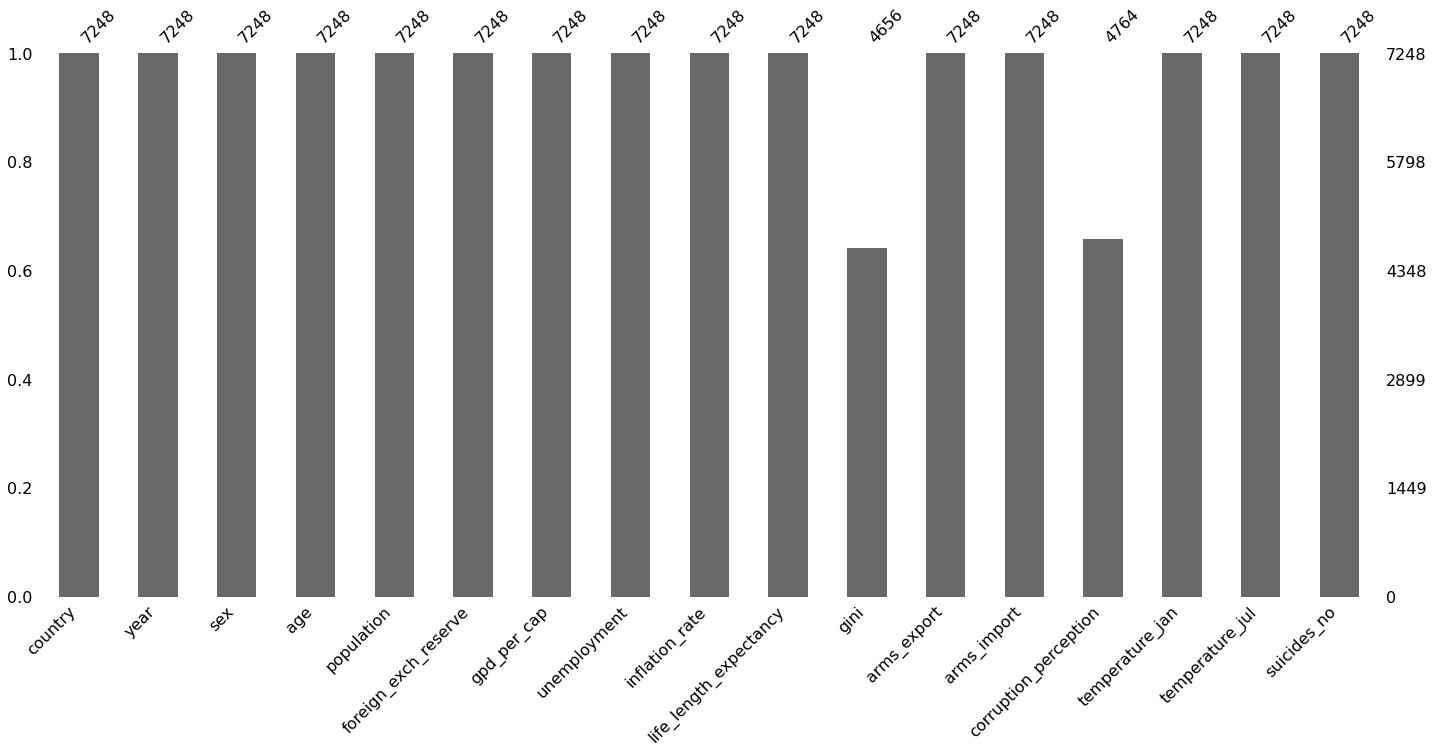

In [17]:
missing_values(df_raw)

**'gini'** and **'corruption_perception'** columns still remain with NaN, but next let's deal with binary cordinality columns categorization to implement LabelEncoder().

### Label Encoding

In [18]:
binary_cardinality_cols = [col_name for col_name in df_raw.columns if df_raw[col_name].nunique() < 3 and 
                                                                   df_raw[col_name].dtype == 'object']; binary_cardinality_cols

['sex']

Next action is Label Encoding for binary cardinality rows.

In [19]:
label_df_raw = df_raw.copy()
label_encoder = LabelEncoder()
for col in binary_cardinality_cols:
    label_df_raw[col] = label_encoder.fit_transform(df_raw[col])

In [20]:
label_df_raw.head(12)

,country,year,sex,age,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,suicides_no
0,Austria,1995,0,15-24 years,495368,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,19
1,Austria,1995,0,25-34 years,678262,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,59
2,Austria,1995,0,35-54 years,1065630,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,136
3,Austria,1995,0,5-14 years,460945,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,0
4,Austria,1995,0,55-74 years,843210,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,141
5,Austria,1995,0,75+ years,341098,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,100
6,Austria,1995,1,15-24 years,509262,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,134
7,Austria,1995,1,25-34 years,707468,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,237
8,Austria,1995,1,35-54 years,1074328,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,437
9,Austria,1995,1,5-14 years,483644,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,8


### One-Hot-Encoder

After binary cardinality will check low cardinality columns.
Maximum number of unique values is 15

In [21]:
low_cardinality_cols = [col_name for col_name in df_raw.columns if 2 < df_raw[col_name].nunique() < 16 and 
                                                                   df_raw[col_name].dtype == 'object']
low_cardinality_cols

['age']

Import One-Hot-Encoder and reform low cardinality columns.

In [22]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # Apply one-hot encoder to each column with categorical data
OH_cols_df = pd.DataFrame(OH_encoder.fit_transform(df_raw[low_cardinality_cols]))

OH_cols_df.index = df_raw.index # One-hot encoding removed index; put it back
OH_cols_df.rename(columns = {0: '15-24 years',
                             1: '25-34 years',
                             2: '35-54 years',
                             3: '5-14 years',
                             4: '55-74 years',
                             5: '75+ years'}, inplace=True)

num_df = label_df_raw.drop(low_cardinality_cols, axis=1) # Remove categorical columns (will replace with one-hot encoding)
OH_df = pd.concat([num_df,OH_cols_df], axis=1) # Add one-hot encoded columns to numerical features

In [23]:
OH_df

,country,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,...,corruption_perception,temperature_jan,temperature_jul,suicides_no,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
0,Austria,1995,0,495368,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,19,1.0,0.0,0.0,0.0,0.0,0.0
1,Austria,1995,0,678262,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,59,0.0,1.0,0.0,0.0,0.0,0.0
2,Austria,1995,0,1065630,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,136,0.0,0.0,1.0,0.0,0.0,0.0
3,Austria,1995,0,460945,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,0,0.0,0.0,0.0,1.0,0.0,0.0
4,Austria,1995,0,843210,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,141,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243,United Kingdom,2015,1,4408293,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,596,0.0,1.0,0.0,0.0,0.0,0.0
7244,United Kingdom,2015,1,8692440,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,1579,0.0,0.0,1.0,0.0,0.0,0.0
7245,United Kingdom,2015,1,3840476,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,4,0.0,0.0,0.0,1.0,0.0,0.0
7246,United Kingdom,2015,1,6716557,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,906,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# print(df_raw.groupby('country').size().sort_values(ascending=False))

### Train and Test set split

Divide all data into test as 20% and train as 80%.

In [25]:
msk = np.random.rand(len(df_raw)) < 0.8 # 1 time (!!)
print(len(df_raw[msk])/len(df_raw))

0.7918046357615894


Initialize two DataFrames according to previuos separation.

In [26]:
train = OH_df[msk]
test = OH_df[~msk]

Split train DataFrame into *X* and *y*.

In [27]:
X,y = train.drop(columns=['suicides_no']), train['suicides_no']
X_test,y_test = test.drop(columns=['suicides_no']), test['suicides_no']

### Train and Validation set split

Split X and y into *test* and *validation*.

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=158)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_valid.shape,  y_valid.shape)

Train set: (4304, 21) (4304,)
Validation set: (1435, 21) (1435,)


#### Simple Imputer

Impute the remaining two columns: *gini* and *corruption_perception*.
Restore columns names and indexes. Dropping *country* column.

In [29]:
features = X_train.columns[1:]

my_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train[features]))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid[features]))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test[features]))

imputed_X_train.columns = X_train[features].columns
imputed_X_valid.columns = X_valid[features].columns
imputed_X_test.columns = X_test[features].columns

imputed_X_train.index = X_train[features].index
imputed_X_valid.index = X_valid[features].index
imputed_X_test.index = X_test[features].index

#### Changing several formats

Form a dictionary for a DataFrame columns with less PC memory consuming data types.

In [30]:
formats = {'sex': 'int8','15-24 years': 'int8',
           '25-34 years': 'int8','35-54 years': 'int8',
           '5-14 years': 'int8','55-74 years': 'int8',
           '75+ years': 'int8', 'year': 'int32'}

BEFORE PRE-PROCESSING

In [31]:
X_train[:2] 

,country,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,...,arms_import,corruption_perception,temperature_jan,temperature_jul,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
2828,France,2010,1,8518205,1.660000e+11,40638.334000,8.8713,1.531123,81.663415,33.7,...,103000000.0,6.8,1.06260,20.9197,0.0,0.0,1.0,0.0,0.0,0.0
4011,Italy,1985,0,3898700,3.739657e+10,7990.686562,9.4065,9.205991,75.470732,NaN,...,206000000.0,NaN,0.89887,21.7534,0.0,0.0,0.0,1.0,0.0,0.0


#### Final train/validation/test

Construct final train/validation/test DataFrames.

In [32]:
X_train = imputed_X_train.copy().astype(formats)
X_valid = imputed_X_valid.copy().astype(formats)
X_test = imputed_X_test.copy().astype(formats)

AFTER PRE-PROCESSING

In [33]:
X_train[:2]

,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
2828,2010,1,8518205.0,1.660000e+11,40638.334000,8.8713,1.531123,81.663415,33.700000,866000000.0,103000000.0,6.800000,1.06260,20.9197,0,0,1,0,0,0
4011,1985,0,3898700.0,3.739657e+10,7990.686562,9.4065,9.205991,75.470732,31.346157,920000000.0,206000000.0,6.768767,0.89887,21.7534,0,0,0,1,0,0


Final check for train/validation/test set shapes.

In [34]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_valid.shape,  y_valid.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4304, 20) (4304,)
Validation set: (1435, 20) (1435,)
Test set: (1509, 20) (1509,)


Function for computing RMSE.

In [62]:
def rmse(x: np.ndarray,y: np.ndarray): 
    '''Root Mean Square Error (RMSE) is the standard deviation of the residuals 
    (prediction errors). Function takes predictions based on trained features as 
    'x' and answers as 'y'.
    Parameters:
    -----------
    (1) x --> predictions ;
    (2) y --> observed values (known results);
    -----------
    Returns RMSE value.
    '''
    return math.sqrt(((x-y)**2).mean())

Function for computing and printing model scores.

In [64]:
def print_score(m):
    '''Function takes a model and calculates and prints its RMSE values and r² 
    scores for train and validation set. Also attaches oob_score for Random 
    Forest model.
    Parameters:
    -----------
    (1) m --> given model;
    -----------
    Returns scoring values in the following order: 
    [training rmse, validation rmse, r² for training set, r² for validation set, 
    oob_score_]
    '''
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    return print(res)

### Random Forest model

In [37]:
# forest_model = RandomForestRegressor(n_jobs=-1, random_state=58)
# forest_model.fit(X_train, y_train)
# valid_preds = forest_model.predict(X_valid)
# print(mean_absolute_error(y_valid,valid_preds))
# print("R2-score Random forest: %.6f" % r2_score(y_valid,valid_preds))

Random Forest model.

In [65]:
forest_model = RandomForestRegressor(n_jobs=-1, random_state=158,oob_score=True) # m = RandomForestRegressor()
forest_model.fit(X_train, y_train)   # m.fit(X_train, y_train)
print_score(forest_model)

[40.463073377826504, 104.08743443728056, 0.9908199719496443, 0.9409939442528432, 0.9333160820622135]


In [61]:
x = forest_model.predict(X_train); type(x)

numpy.ndarray

### Linear Regression model

In [39]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print_score(regr)

[260.86301672800016, 271.8005003802866, 0.6184501389479591, 0.5976532655109332]


Linear Regression Coefficients and Intercept value along with column names.

In [40]:
print ('Coefficients: ', regr.coef_)
print()
print ('Intercept: ',regr.intercept_)
print()
print(f'Column names: {list(X_train.columns)}')

Coefficients:  [-7.89739249e-01  2.15374209e+02  1.15113001e-04  5.05045235e-10
  6.34048389e-04  2.87769354e-01 -7.92409539e+00 -1.83016306e+01
 -8.66100998e+00  5.70310944e-08 -9.05516720e-08  4.11680500e+00
 -3.52801123e+00  7.96300978e+00 -8.35202337e+01 -2.43378379e+01
  8.81460429e+01 -1.69900814e+02  1.08870134e+02  8.07427088e+01]

Intercept:  2990.6269708235673

Column names: ['year', 'sex', 'population', 'foreign_exch_reserve', 'gpd_per_cap', 'unemployment', 'inflation_rate', 'life_length_expectancy', 'gini', 'arms_export', 'arms_import', 'corruption_perception', 'temperature_jan', 'temperature_jul', '15-24 years', '25-34 years', '35-54 years', '5-14 years', '55-74 years', '75+ years']


### DecisionTreeRegressor model

Function for finding MAE score.

In [76]:
def get_mae(max_leaf_nodes: list, train_X: pd.DataFrame, val_X: pd.DataFrame,train_y: pd.Series, val_y:pd.Series) -> np.float64:
    '''Mean Absolute Error (MAE) evaluates the average dimension
    of the error in a predictions set. Function takes X and y 
    from the training and validation sets.
    Parameters:
    -----------
    (1) max_leaf_nodes --> list of possible 'max_leaf_nodes' values;
    (2) train_X --> training set of independent features;
    (3) val_X --> validation set of independent features;
    (4) train_y --> training set of dependent features;
    (5) val_y --> validation set of dependent features;
    -----------
    Returns MAE value.
    '''
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=158)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return mae

Loop in order to find best 'max_leaf_nodes' parameter's argument.

In [75]:
for max_leaf_nodes in [5, 50, 250, 350, 500]:
    my_mae = get_mae(max_leaf_nodes, X_train, X_valid,y_train, y_valid)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:%d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:144
Max leaf nodes: 50  		 Mean Absolute Error:81
Max leaf nodes: 250  		 Mean Absolute Error:53
Max leaf nodes: 350  		 Mean Absolute Error:51
Max leaf nodes: 500  		 Mean Absolute Error:49


DecisionTreeRegressor model and score.

In [43]:
model = DecisionTreeRegressor(max_leaf_nodes=350, random_state=158, max_features=0.5)
model.fit(X_train, y_train)
print_score(model)

[26.982386584730357, 154.0328896630475, 0.9959178684547304, 0.8707808432052841]


### K-Nearest Neighbors model

Loop to find K value for the model comparing error rate.

Minimum error:- 0.9310104529616725 at K = 95


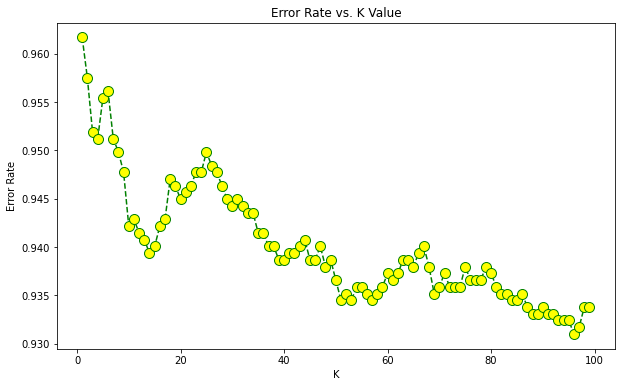

In [44]:
error_rate = []          ## from https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_valid)
    error_rate.append(np.mean(pred_i != y_valid))

plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='green', linestyle='dashed', 
         marker='o',markerfacecolor='yellow', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Loop to find K value for the model comparing accuracy.

Maximum accuracy:- 0.06898954703832752 at K = 95


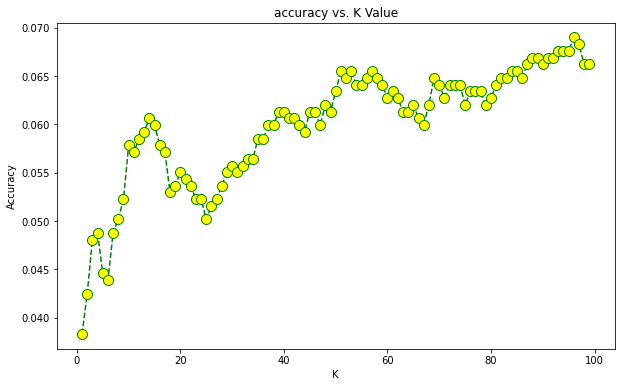

In [45]:
acc_list = []                    ## from https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb
from sklearn import metrics
for i in range(1,100):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_valid)
    acc_list.append(metrics.accuracy_score(y_valid, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,100),acc_list,color = 'green',linestyle='dashed', 
         marker='o',markerfacecolor='yellow', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc_list),"at K =",acc_list.index(max(acc_list)))

K-Nearest Neighbors model and score.

In [77]:
k=95
neigh = KNeighborsClassifier(n_neighbors = k,n_jobs=-1)
neigh.fit(X_train,y_train)
print_score(neigh)

[474.0869955204017, 473.09522433564956, 0.07272304832713755, 0.06759581881533101]


#### Scaling for Logistic Regression model and Support Vector Regression model

Scale data to \[-1,1\] and increase model speed.

In [47]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train_scaler = scaling.transform(X_train)
X_valid_scaler = scaling.transform(X_valid)

### Logistic Regression model

Function for model scoring after scaling.

In [48]:
def print_score_scaler(m):
    '''Function takes a model and calculates and prints its RMSE values and r² 
    scores for train and validation sets, but both sets should be scaled.
    Parameters:
    -----------
    (1) m --> given model;
    -----------
    Returns scoring values in the following order: [training rmse, validation -
    rmse, r² for training set, r² for validation set] 
    '''
    res = [rmse(m.predict(X_train_scaler), y_train),
           rmse(m.predict(X_valid_scaler), y_valid),
           m.score(X_train_scaler, y_train), m.score(X_valid_scaler, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res) 

Loop through 4 models to evaluate accuracy and choose the best performed solver model.

In [59]:
list_lr = ['newton-cg', 'liblinear', 'sag']
for solver in list_lr:
    lr = linear_model.LogisticRegression(C=0.9, solver=solver).fit(X_train_scaler,y_train)
    y_hat = lr.predict(X_valid_scaler)
    mean_acc = accuracy_score(y_valid,y_hat)
    print(f'"{solver}" kernel model accuracy score: {mean_acc.round(6)}')

"newton-cg" kernel model accuracy score: 0.087805
"liblinear" kernel model accuracy score: 0.08223
"sag" kernel model accuracy score: 0.087805


Logistic Regression model with solver as "newton-cg" and model's score.

In [55]:
logreg = linear_model.LogisticRegression(C=0.9, solver='newton-cg')
logreg.fit(X_train_scaler,y_train)
print_score_scaler(logreg) 

[310.8124326053927, 296.169798976506, 0.1171003717472119, 0.08780487804878048]


### Support Vector Regression model

Loop through 4 models to evaluate accuracy and choose the best performed kernel model.

In [51]:
list_svm = ['linear', 'rbf', 'sigmoid','poly']
for model in list_svm:
    svm = SVC(kernel=model).fit(X_train_scaler,y_train)
    y_hat = svm.predict(X_valid_scaler)
    mean_acc = accuracy_score(y_valid,y_hat)
    print(f'{model} kernel model accuracy score: {mean_acc.round(6)}')

linear kernel model accuracy score: 0.088502
rbf kernel model accuracy score: 0.081533
sigmoid kernel model accuracy score: 0.067596
poly kernel model accuracy score: 0.092683


**Support Vector Regression** model with kernel as "poly" and model's score.

In [52]:
svm = SVC(kernel='poly')
svm.fit(X_train_scaler,y_train)
print_score_scaler(svm) 

[323.34176727812746, 313.79960315584617, 0.16984200743494424, 0.09268292682926829]


#  Final scores

| Algorithm            |  RMSE    |    r²    |
| -------------------- | -------- | -------- |
| Random Forest        | 104.0874 | 0.9410   |
| DecisionTreeRegressor| 154.0329 | 0.8708   |
| LinearRegression     | 271.8005 | 0.5977   | 
| SVM                  | 313.7996 | 0.0927   |
| LogisticRegression   | 296.1698 | 0.0878   |
| K-Nearest Neighbors  | 473.0952 | 0.0676   |

### Next model TBC..

In [53]:
### To-Do list:
# * Catboost for countries; // RobustScaler
# * SGD model;
# * XGboost model;